# imports

In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# problem setup

\begin{align*}
    J[u] &= \int_{0}^{t_f} \frac{1}{2}u(t)^2 \, dt - exp\left(\frac{-(y(t_f) - \frac{(P_l+P_u)}{2})^2}{\sigma^2}\right)
\end{align*}

\begin{align*}
\mathbf{x}(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix} &
\mathbf{x}'(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix}' =  \begin{bmatrix} y'(t) \\ u(t) - 9.8 \end{bmatrix} &
\mathbf{x}(0) &= \begin{bmatrix} y_0 \\ 0 \end{bmatrix} &
\mathbf{x}(t_f) &= \begin{bmatrix} \text{free} \\ 0 \end{bmatrix} &
\end{align*}

\begin{equation}
H = \mathbf{p} \cdot \mathbf{f} - L 
 = p_0 y' + p_1 (u - 9.8) - \frac{1}{2} u^2
\end{equation}

\begin{align*}
p_0' &= -\frac{\partial H}{\partial y} = 0 \\
p_1' &= -\frac{\partial H}{\partial y'} = -p_0
\end{align*}

\begin{align*}
p_0(t_f) &= -\frac{\partial \phi}{\partial y(t_f)} = \left(\frac{-1}{\sigma^2}\right) \left( 2y(t_f) - (L+U) \right) \exp\left(\frac{-(y(t_f) - \frac{(P_l+P_u)}{2})^2}{\sigma^2}\right) \\
p_1(t_f) &= \text{free}
\end{align*}

\begin{align*}
\frac{ \partial H}{\partial u} = 0 = p_1 - u \implies \tilde{u} = p_1
\end{align*}

# solve the simple $\frac{1}{2}u(t)^2$ version

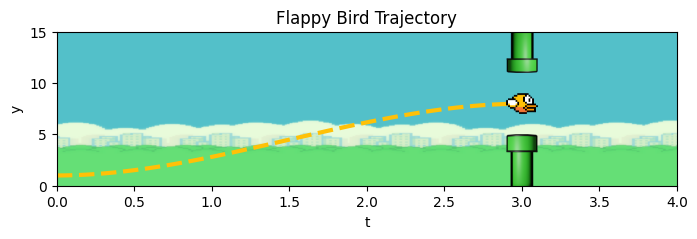

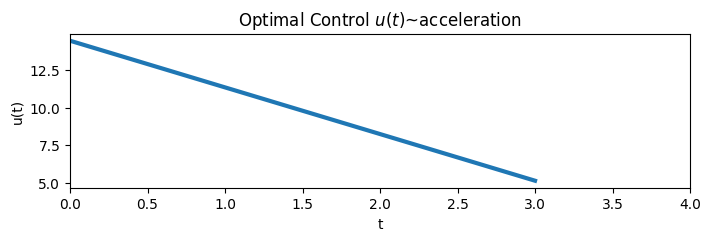

In [3]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 3
L, U = 5, 11
sigma2 = 0.1**2
Sy = 1
g = 9.8
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (L+U)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (L+U)/2) * phi(y_tf)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    u = p1
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - Sy,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
    ])

# setup an intial guess for the solution
y_guess = np.linspace(Sy, (U+L)/2, t_steps)
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.ones(t_steps)
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0)

# extract the values from the solution
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
u = p1

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,2)
xlims = (0, 4)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = U, ylims[1]
img = mpimg.imread('images/pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = ylims[0], L
img = mpimg.imread('images/pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = 2.9, 3.1
ymin, ymax = 7, 9
bird = mpimg.imread('images/bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$~acceleration")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# similar-to-sine version

\begin{align*}
    J[u] &= \int_{0}^{t_f} \left(u(t) - max\{0, sin(\alpha t)\} \right)^2 \, dt - exp\left(\frac{-(y(t_f) - \frac{(P_l+P_u)}{2})^2}{\sigma^2}\right)
\end{align*}

\begin{align*}
\mathbf{x}(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix} &
\mathbf{x}'(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix}' =  \begin{bmatrix} y'(t) \\ u(t) - 9.8 \end{bmatrix} &
\mathbf{x}(0) &= \begin{bmatrix} y_0 \\ 0 \end{bmatrix} &
\mathbf{x}(t_f) &= \begin{bmatrix} \text{free} \\ 0 \end{bmatrix} &
\end{align*}

\begin{equation}
H = \mathbf{p} \cdot \mathbf{f} - L 
 = p_0 y' + p_1 (u - 9.8) - \left(u(t) - max\{0, sin(\alpha t)\} \right)^2
\end{equation}

\begin{align*}
p_0' &= -\frac{\partial H}{\partial y} = 0 \\
p_1' &= -\frac{\partial H}{\partial y'} = -p_0
\end{align*}

\begin{align*}
p_0(t_f) &= -\frac{\partial \phi}{\partial y(t_f)} = \left(\frac{-1}{\sigma^2}\right) \left( 2y(t_f) - (L+U) \right) \exp\left(\frac{-(y(t_f) - \frac{(P_l+P_u)}{2})^2}{\sigma^2}\right) \\
p_1(t_f) &= \text{free}
\end{align*}

\begin{align*}
\frac{ \partial H}{\partial u} = 0 = p_1 + 2(u(t) - sin(\alpha t)) \implies \tilde{u} = -\frac{p_1}{2} + sin(\alpha t)
\end{align*}

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.48e-02       2.71e-07          100             6       
       2          1.23e-02       9.46e-09          106             6       
       3          6.40e-03       9.79e-10          112             5       
       4          2.81e-03       1.05e-11          117             5       
       5          1.32e-03       6.24e-13          122             3       
       6          9.72e-04       2.12e-14          125             0       
Solved in 6 iterations, number of nodes 125. 
Maximum relative residual: 9.72e-04 
Maximum boundary residual: 2.12e-14


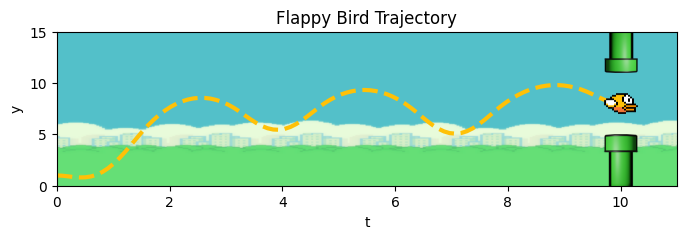

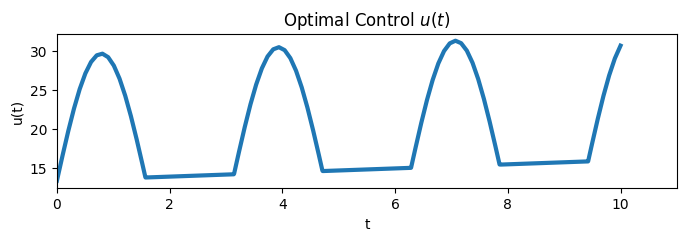

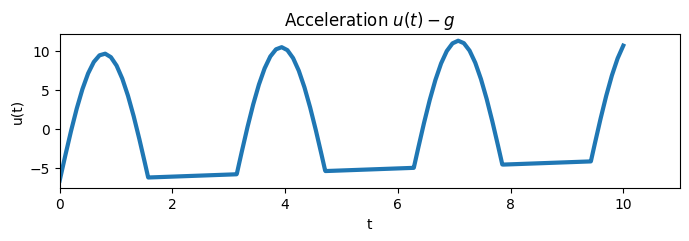

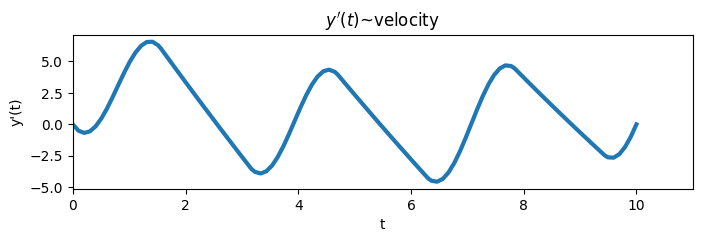

[13.4196523  16.6564342  19.76263848 22.6129986  25.09265406 27.10182229
 28.55985707 29.40852874 29.61439261 29.17014924 28.09494139 26.43357536
 24.25469859 21.64800752 18.72059931 15.59261584 13.99332479 13.89314242
 13.83050534 13.83215535 13.83545537 13.84205542 13.86845562 13.89485581
 13.92125601 13.9476562  13.9740564  14.00045659 14.02685679 14.05325698
 14.07965718 14.10605737 14.13245757 14.15885776 14.18525796 14.21165816
 14.23805835 14.23970836 14.31645379 14.72372289 15.53708724 17.15192946
 20.27727843 23.15913847 25.68136789 27.74245248 29.25963439 30.17227824
 30.44433737 30.06581994 29.0531954  27.44872456 25.31874075 22.75095174
 19.85087242 16.7375331  15.14060024 14.7399376  14.65221141 14.65386142
 14.66046147 14.68686167 14.71326186 14.73966206 14.76606225 14.79246245
 14.81886264 14.84526284 14.87166303 14.89806323 14.92446343 14.95086362
 14.97726382 15.00366401 15.03006421 15.0564644  15.05976443 15.06141444
 15.11142065 15.21325363 16.0273639  17.64620431 20

In [4]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 10
L, U = 5, 11
sigma2 = 0.1**2
Sy = 1
g = 20
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (L+U)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (L+U)/2) * phi(y_tf)

TAPS = 2
TAP_FORCE = 0.8*g

def u_f(p1, t):
    sin_part = np.sin(TAPS*t)
    sin_part = np.clip(sin_part, 0, np.abs(sin_part))
    res = -p1/2 + TAP_FORCE*sin_part
    res = np.clip(res, 0, np.abs(res))
    return res

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    
    u = u_f(p1, t)
    
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
    
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - Sy,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
    ])

# setup an intial guess for the solution
y_guess = np.linspace(Sy, (U+L)/2, t_steps)
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.sin(TAPS*np.linspace(t0, tf, t_steps))
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0, verbose=2)

# extract the values from the solution
t = sol.x
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
#u = fsolve(lambda u: p1*np.cos(u) - np.cos(u), np.linspace(0, 2*np.pi, len(y)))
u = u_f(p1, t)

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,2)
xlims = (0, tf+1)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
PIPE_WIDTH = 0.3
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = U, ylims[1]
img = mpimg.imread('images/pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = ylims[0], L
img = mpimg.imread('images/pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = L+2, U-2
bird = mpimg.imread('images/bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# plot the u(t)
plt.title("Acceleration $u(t)-g$")
plt.plot(t, u - g, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# plot the velocity
plt.title("$y'(t)$~velocity")
plt.plot(t, yp, linewidth=3)
plt.xlabel("t")
plt.ylabel("y'(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

print(u)